In [1]:
import scPhyloX as spx
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.lines as mlines
from scipy.stats import poisson

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [40]:
import gzip
import pandas as pd

In [2]:
plt.rcParams['font.size'] = 12
plt.rcParams['pdf.fonttype'] = 42

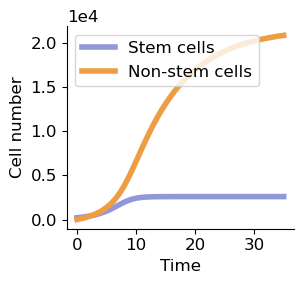

In [4]:
p, r, a, b, k, t0 = (0.6, 1, 0.2, 0.375, 0.8, 8)
r1, b1 = (0.3, 0.3)
K = 35
x0 = [200, 0]
mut_rate = 2
sol = solve_ivp(spx.est_haem.cellnumber, t_span=(0, K+1), y0=x0, 
                method='RK45', t_eval=np.linspace(0, K, 50), args=(r, a, b, k, t0, p, r1, b1))
fig, ax = plt.subplots(1, 1, figsize=(3.2, 3))
ax.plot(sol.t, sol.y[0], label='Stem cells', c='#9098d9', lw=4)
ax.plot(sol.t, sol.y[1], label='Non-stem cells', c='#ed9e44', lw=4)
ax.legend(loc=2)

ax.ticklabel_format (style='sci', scilimits= (-1,2), axis='y')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Time')
ax.set_ylabel('Cell number')
plt.tight_layout()

In [5]:
mu = 2
system = spx.sim_haem.simulation(x0, K, mu, a, b, p, r, k, t0, r1, b1)

cell_num:23937, time:35.0000421572501255

Text(0, 0.5, 'Cell number')

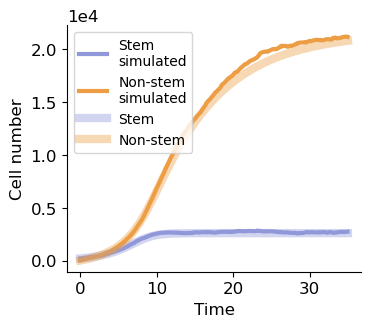

In [7]:
cell_number = np.array(system.n)
fig, ax = plt.subplots(figsize=(3.8, 3.2))
show_tp = np.arange(0, len(system.t),1000)
ax.plot(np.array(system.t)[np.arange(0, len(system.t),1000)], cell_number[np.arange(0, len(system.t),1000), 0], lw=3, label='Stem\nsimulated', c='#9098d9')
ax.plot(np.array(system.t)[np.arange(0, len(system.t),1000)], cell_number[np.arange(0, len(system.t),1000), 1], lw=3, label='Non-stem\nsimulated', c='#ed9e44')
ax.plot(sol.t, sol.y[0], label='Stem', c='#9098d9', lw=6, alpha=0.4)
ax.plot(sol.t, sol.y[1], label='Non-stem', c='#ed9e44', lw=6, alpha=0.4)
ax.legend(loc=2,fontsize=10)
ax.ticklabel_format (style='sci', scilimits= (-1,2), axis='y')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Time')
ax.set_ylabel('Cell number')

In [8]:
seqtab = np.array([i.seq for i in system.Stemcells] + [i.seq for i in system.Diffcells])
seqtab = seqtab[np.random.choice(range(seqtab.shape[0]), 500, replace=False)]

In [9]:
branch_len = spx.data_factory.get_branchlen(seqtab)
mutnum = spx.data_factory.get_mutnum(seqtab)
ge = spx.est_mr.GenerationEst(mutnum, 2)
gen_num = ge.estimate(cell_number[-1].sum())

100%|██████████| 125250/125250 [00:03<00:00, 40776.70it/s]


In [11]:
p, r, a, b, k, t0 = (0.6, 1, 0.2, 0.375, 0.8, 8)
r1, b1 = (0.3, 0.3)
ast, bst = a*(1+p), b*(1+p)+1-p

In [17]:
nsc = np.array([[spx.est_haem.stem_num(i, j, 100, *[ast, bst, r, k, t0, r1, b1]) for j in range(K)] for i in range(100)])
nnc = solve_ivp(spx.est_haem.nstem_num, t_span=(0, K), y0=[0]*100, method='RK45', args=(100, ast, bst, r, k, t0, r1, b1)).y[:,-1]

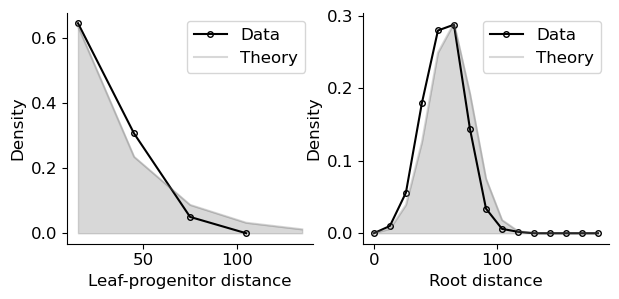

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
max_val = 150
n_hist = 5
xrange = np.arange(0, max_val, int(max_val/n_hist))+int(max_val/n_hist)/2
dist = np.histogram(branch_len+1, xrange-int(max_val/n_hist)/2)
th_dist = [spx.est_mr.BranchLength(2, 0.065).prob(i) for i in xrange]
ax[0].plot(xrange[:-1], dist[0]/sum(dist[0]), 'o-', mfc='none', c='black', ms=4, label='Data')
ax[0].plot(xrange, th_dist/sum(th_dist), c='tab:grey',alpha=0.3, label='Theory')
ax[0].fill_between(xrange, th_dist/sum(th_dist), color='tab:grey', alpha=0.3)
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_xlabel('Leaf-progenitor distance')
ax[0].set_ylabel('Density')
ax[0].legend()


alpha = nsc[:,-1]+nnc
alpha = alpha / sum(alpha)
max_val = 200
n_hist = 15
mutdist = np.histogram(mutnum, np.arange(0, max_val, int(max_val/n_hist)))
th_dist = np.zeros(max_val)
for i, a in enumerate(alpha):
    th_dist = th_dist + a*poisson((i+1)*2).pmf(range(max_val))
th_dist_x = []
th_dist_y = []
for i in range(n_hist):
    th_dist_x.append(i*int(max_val/n_hist))
    th_dist_y.append(np.sum(th_dist[i*int(max_val/n_hist):(i+1)*int(max_val/n_hist)]))
ax[1].plot(mutdist[1][:-1], mutdist[0]/sum(mutdist[0]), 'o-', mfc='none', c='black', ms=4, label='Data')
ax[1].plot(th_dist_x, th_dist_y, c='tab:grey',alpha=0.3, label='Theory')
ax[1].fill_between(th_dist_x, th_dist_y, color='tab:grey', alpha=0.3)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].set_xlabel('Root distance')
ax[1].set_ylabel('Density')
ax[1].legend()

In [41]:
with gzip.open('../datasets/simulation/haematopoiesis/character_matrix.csv.gz', 'wb') as f:
    pd.DataFrame(seqtab).to_csv(f)
    
with gzip.open('../datasets/simulation/haematopoiesis/simulation_data.csv.gz', 'wb') as f:
    pd.DataFrame(np.concatenate((np.array(system.t).reshape(-1,1),cell_number), axis=1)).to_csv(f)